In [1]:
%pip install -q python-dotenv matplotlib numpy pandas scikit-learn tqdm xgboost hyperopt sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import random
from typing import Any, Dict, Optional, Union

import joblib
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from hyperopt import STATUS_OK, hp, Trials, fmin, tpe
from matplotlib import pyplot as plt
from numpy import average, ndarray
from pandas import read_csv, DataFrame
from sklearn import clone
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.contrib.itertools import product
from xgboost import XGBClassifier

/home/cela/code/GitHub/msc-thesis/.conda/lib/python3.11/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
load_dotenv()
os.chdir(os.getenv("ROOT"))

CV = int(os.getenv("CV"))
RETRAIN = True
OVERWRITE = False
RANDOM_STATE = int(os.getenv("RANDOM_STATE"))
TEST_SIZE = float(os.getenv("TEST_SIZE"))

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [4]:
from notebooks.utils import preprocess_texts, replace_text_components

In [ ]:
CLASSIFIERS = {
    "lr": LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE),
    "gnb": GaussianNB(),
    "rf": RandomForestClassifier(random_state=RANDOM_STATE),
    "xgb": XGBClassifier(random_state=RANDOM_STATE)
}

EMBEDDING_SOURCES = [
    {'name': 'GloVe.6B.50D', 'model-path': os.getenv("GLOVE_6B_50D_PATH"), 'embedding-dim': 50},
    {'name': 'GloVe.6B.100D', 'model-path': os.getenv("GLOVE_6B_100D_PATH"), 'embedding-dim': 100},
    {'name': 'GloVe.6B.200D', 'model-path': os.getenv("GLOVE_6B_200D_PATH"), 'embedding-dim': 200},
    {'name': 'GloVe.6B.300D', 'model-path': os.getenv("GLOVE_6B_300D_PATH"), 'embedding-dim': 300},
    {'name': 'DistilRoBERTa', 'model-path': os.getenv("DISTILROBERTA_PATH"), 'embedding-dim': None},
    {'name': 'SBERT', 'model-path': os.getenv("SBERT_PATH"), 'embedding-dim': None},
    {"name": "ATT&CK-BERT", "model-path": os.getenv("ATTACK_BERT_PATH"), "embedding-dim": None},
]

In [6]:
def train_classifier(
        x: ndarray, y: ndarray, cv: int = 1, random_state: Optional[int] = None, test_size: float = 0.2,
        base_estimator: Optional[ClassifierMixin] = None
) -> Dict[str, Union[float, Any]]:
    classifier_dict = {}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', clone(base_estimator))
    ])

    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=y
    )

    classifier_dict['cv-accuracy'] = average(a=cross_val_score(
        estimator=pipeline,
        X=x,
        y=y,
        scoring='balanced_accuracy',
        cv=cv
    ))

    pipeline.fit(X=x_train, y=y_train)
    y_predicted_test = pipeline.predict(X=x_test)
    y_predicted_train = pipeline.predict(X=x_train)
    fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=pipeline.predict_proba(x_train)[:, 1])
    fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=pipeline.predict_proba(x_test)[:, 1])

    classifier_dict['model'] = pipeline

    classifier_dict['train'] = {
        'accuracy': balanced_accuracy_score(y_true=y_train, y_pred=y_predicted_train),
        'precision': precision_score(y_true=y_train, y_pred=y_predicted_train),
        'recall': recall_score(y_true=y_train, y_pred=y_predicted_train),
        'f1': f1_score(y_true=y_train, y_pred=y_predicted_train),
        'fpr': fpr_train,
        'tpr': tpr_train,
        'auc': auc(x=fpr_train, y=tpr_train)
    }

    classifier_dict['test'] = {
        'accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_predicted_test),
        'precision': precision_score(y_true=y_test, y_pred=y_predicted_test),
        'recall': recall_score(y_true=y_test, y_pred=y_predicted_test),
        'f1': f1_score(y_true=y_test, y_pred=y_predicted_test),
        'fpr': fpr_test,
        'tpr': tpr_test,
        'auc': auc(x=fpr_test, y=tpr_test)
    }

    return classifier_dict

In [7]:
with open(os.getenv("FILTER_TRAIN_CSV"), 'rb') as f:
    tweets = pd.read_csv(f)

texts = tweets['text']
texts = pd.Series([replace_text_components(t) for t in texts])
target = tweets['relevant']

models_dict = {}

for (embedding_info, classifier_name) in product(EMBEDDING_SOURCES, CLASSIFIERS, desc="Training models", unit="model"):
    x = preprocess_texts(
        list_str=texts,
        model_path=embedding_info['model-path'],
        embedding_dim=embedding_info['embedding-dim']
    )

    model_name = f"{classifier_name.upper()} {embedding_info['name']}"

    model_dict = train_classifier(
        x=x,
        y=target,
        cv=CV,
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE,
        base_estimator=CLASSIFIERS[classifier_name]
    )

    model_dict['name'] = model_name

    try:
        if model_dict['cv-accuracy'] > models_dict[model_name]['cv-accuracy']:
            models_dict[model_name] = model_dict
    except KeyError:
        models_dict[model_name] = model_dict

    print(
        f"· {classifier_name.upper()} {embedding_info['name']} - CV Accuracy:\t{models_dict[model_name]['cv-accuracy'] * 100:.2f}%"
    )

Training models:   0%|          | 0/1 [00:00<?, ?model/s]

· RF SBERT - CV Accuracy:	81.34%


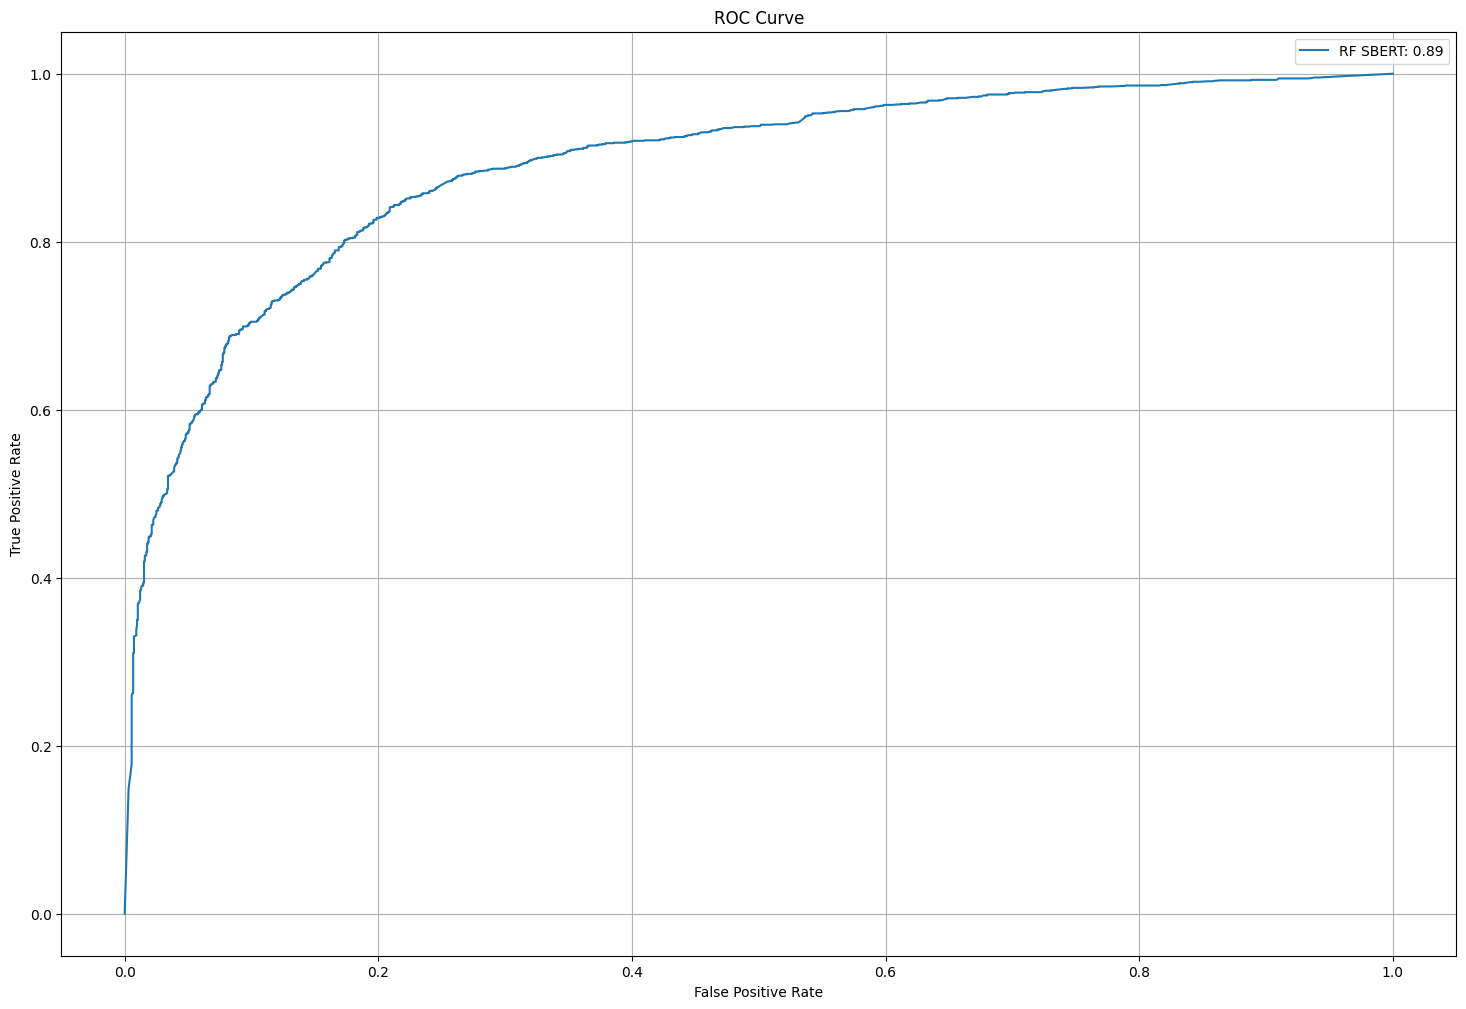

In [8]:
plt.figure(figsize=(18, 12))

for name, model_dict in models_dict.items():
    plt.plot(
        model_dict['test']['fpr'], model_dict['test']['tpr'],
        label=f"{name}: {model_dict['test']['auc']:.2f}"
    )

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
optimal_model = models_dict[list(models_dict.keys())[np.argmax([v["cv-accuracy"] for v in models_dict.values()])]]

optimal_model

{'cv-accuracy': np.float64(0.8134045435105979),
 'model': Pipeline(steps=[('scaler', StandardScaler()),
                 ('estimator', RandomForestClassifier(random_state=42))]),
 'train': {'accuracy': 0.9681186424787886,
  'precision': 0.9721279003961517,
  'recall': 0.9662494726480101,
  'f1': 0.9691797729035898,
  'fpr': array([0.        , 0.        , 0.        , ..., 0.94667885, 0.9468312 ,
         1.        ], shape=(1628,)),
  'tpr': array([0.        , 0.20559696, 0.20601884, ..., 1.        , 1.        ,
         1.        ], shape=(1628,)),
  'auc': 0.9945221271881733},
 'test': {'accuracy': 0.8116201539706989,
  'precision': 0.8276460381723539,
  'recall': 0.8048368953880765,
  'f1': 0.8160821214713431,
  'fpr': array([0.        , 0.00304692, 0.00304692, ..., 0.95368678, 0.95429616,
         1.        ], shape=(1097,)),
  'tpr': array([0.        , 0.14341957, 0.143982  , ..., 0.99662542, 0.99662542,
         1.        ], shape=(1097,)),
  'auc': 0.8893787156861334},
 'name': '

In [ ]:
with open(os.getenv("FILTER_MODELS"), 'wb') as f:
    pickle.dump(models_dict, f)

In [10]:
with open(os.getenv("FILTER_MODELS"), 'rb') as f:
    models_dict = pickle.load(f)

/home/cela/code/GitHub/msc-thesis/.conda/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/cela/code/GitHub/msc-thesis/.conda/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/cela/code/GitHub/msc-thesis/.conda/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Pi

In [11]:
performances = DataFrame()

for i, name in zip(DataFrame(data=models_dict.values(), index=models_dict.keys())['train'], models_dict.keys()):
    performances[name] = DataFrame(data=i.values(), index=[c.upper() for c in i.keys()])

performances = performances.T.drop(labels=['FPR', 'TPR'], axis=1)
performances

,ACCURACY,PRECISION,RECALL,F1,AUC
LR GloVe.6B.50D,0.75283,0.755562,0.778512,0.766865,0.837946
GNB GloVe.6B.50D,0.693491,0.725393,0.656026,0.688968,0.765902
RF GloVe.6B.50D,0.965746,0.9692,0.964703,0.966946,0.993266
XGB GloVe.6B.50D,0.958814,0.961517,0.959218,0.960366,0.992264
LR GloVe.6B.100D,0.756328,0.761925,0.774996,0.768405,0.844219
GNB GloVe.6B.100D,0.684122,0.7001,0.687104,0.693542,0.764447
RF GloVe.6B.100D,0.965728,0.968803,0.965124,0.96696,0.993208
XGB GloVe.6B.100D,0.961943,0.965659,0.960906,0.963276,0.993247
LR GloVe.6B.200D,0.776127,0.792202,0.771481,0.781704,0.859502
GNB GloVe.6B.200D,0.691218,0.738215,0.62101,0.674559,0.769633


In [12]:
performances = DataFrame()

for i, name in zip(DataFrame(data=models_dict.values(), index=models_dict.keys())['test'], models_dict.keys()):
    performances[name] = DataFrame(data=i.values(), index=[c.upper() for c in i.keys()])

performances = performances.T.drop(labels=['FPR', 'TPR'], axis=1)
performances["CV Accuracy"] = pd.Series({k: v["cv-accuracy"] for k, v in models_dict.items()})
performances

,ACCURACY,PRECISION,RECALL,F1,AUC,CV Accuracy
LR GloVe.6B.50D,0.745129,0.745818,0.777278,0.761223,0.837101,0.749833
GNB GloVe.6B.50D,0.678762,0.70872,0.644544,0.67511,0.756231,0.691726
RF GloVe.6B.50D,0.793317,0.816085,0.776153,0.795618,0.872634,0.796445
XGB GloVe.6B.50D,0.792191,0.807139,0.788526,0.797724,0.872903,0.793553
LR GloVe.6B.100D,0.752911,0.757993,0.773341,0.76559,0.843286,0.755101
GNB GloVe.6B.100D,0.669666,0.686173,0.672666,0.679352,0.752455,0.681676
RF GloVe.6B.100D,0.786756,0.816475,0.758155,0.786235,0.868122,0.790788
XGB GloVe.6B.100D,0.790458,0.809942,0.778965,0.794151,0.871577,0.789808
LR GloVe.6B.200D,0.770254,0.782263,0.773903,0.778061,0.855273,0.768517
GNB GloVe.6B.200D,0.685701,0.727869,0.624297,0.672116,0.760279,0.691465


In [13]:
# Round all values to 4 decimal places
performances = performances * 100

for idx, row in performances.iterrows():
    for col in performances.columns:
        performances.at[idx, col] = round(row[col], 2)

performances.to_csv(os.getenv("FILTERS_PERFORMANCES_CSV"), header=True, sep='&')

In [14]:
with open(os.getenv("FILTER_TEST_CSV"), 'rb') as f:
    test_tweets = pd.read_csv(f)

texts = test_tweets['text']
texts = pd.Series([replace_text_components(t) for t in texts])
target = test_tweets['relevant']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    preprocess_texts(
        list_str=texts,
        model_path='sentence-transformers/all-mpnet-base-v2',
        embedding_dim=None,
    ), target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=target
)

In [ ]:
def objective(params):
    """
    Objective function for hyperopt to minimize the loss of a xgb model with given parameters over a dataset with a 5-fold cross-validation.

    Parameters
    ----------
    params : dict
        Dictionary containing the parameters for the xgboost model.

    Returns
    -------
    dict
        Dictionary containing the loss and status of the objective function.
    """
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        objective='binary:logistic',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    score = cross_val_score(
        estimator=clf,
        X=x_train,
        y=y_train,
        scoring='balanced_accuracy',
        cv=2
    ).mean()
    return {
        'loss': -score,
        'status': STATUS_OK
    }


space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.choice('max_depth', [0, 10, 20, 30, 40, 50]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(seed=RANDOM_STATE)
)

print("Best parameters:")
print(best)

In [ ]:
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': None if best['max_depth'] == 0 else [None, 10, 20, 30, 40, 50][best['max_depth']],
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_features': ['sqrt', 'log2', None][best['max_features']],
    'bootstrap': [True, False][best['bootstrap']]
}

final_clf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=RANDOM_STATE)
final_clf.fit(x_train, y_train)

test_accuracy = final_clf.score(x_test, y_test)
print(f"\nTest Accuracy: {test_accuracy * 100:.4f}%")

# Performance over Cotov's Dataset


In [ ]:
cotov = read_csv(filepath_or_buffer=os.getenv("COTOV_CSV"))
cotov = cotov[cotov['lang'] == 'en']
model_name = "RF SBERT"

cotov[f'{model_name}'] = optimal_model["model"].predict(X=preprocess_texts(
    list_str=cotov[cotov['lang'] == 'en']['full_text'],
    model_path=os.getenv("SBERT_PATH"),
    embedding_dim=None,
))

In [ ]:
rf_accuracy = balanced_accuracy_score(
    y_true=cotov['Related'],
    y_pred=cotov[f'{model_name}']
)
print(f"Accuracy of prediction over Cotov's dataset is:\t{rf_accuracy * 100:.2f}")
print(classification_report(y_true=cotov['Related'], y_pred=cotov[f'{model_name}']))

In [ ]:
if OVERWRITE:
    joblib.dump(final_clf, os.getenv("OPTIMAL_FILTER_PICKLE"), compress=9)

optimal_filter = joblib.load(os.getenv("OPTIMAL_FILTER_PICKLE"))
optimal_filter

In [ ]:
optimal_filter.predict(X=preprocess_texts(
    list_str=pd.Series(['I\'m studying computer security', 'That\'s a teardrop']),
    model_path='sentence-transformers/all-mpnet-base-v2',
    embedding_dim=None,
))